In [1]:
import sys, os
from charm.infer_halos_from_PM import get_model_interface
import matplotlib.pyplot as pl
import pathlib
import pickle as pk
import numpy as np
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../charm/") 
%load_ext autoreload
%autoreload 2
%matplotlib inline




In [2]:
src_path = '/mnt/home/spandey/ceph/CHARM/charm'
run_config_massNtot_name = f'{src_path}/trained_configs/train_massNtot_config.yaml'
run_config_vel_name = f'{src_path}/trained_configs/train_vel_config.yaml'
trained_massmodel_name = f'{src_path}/trained_models/charm_model_massNtot_bestfit_v2.pth'
trained_velmodel_name = f'{src_path}/trained_models/charm_model_vel_bestfit_v2.pth'


In [2]:
a_snap_all = np.loadtxt('/mnt/home/spandey/ceph/CHARM/data/camels_snap_scalefac.txt')
z_snap_all = 1/a_snap_all - 1
indsel = np.where((z_snap_all >= 0.3) & (z_snap_all <= 0.7))[0]
a_snap_sel = a_snap_all[indsel]
z_snap_sel = z_snap_all[indsel]
snap_num_array = indsel


In [10]:
z_snap_all


array([14.98917323, 13.3382483 , 11.98021331, 11.20478521, 10.47568058,
        9.68836111,  9.00233986,  8.49435712,  8.01217293,  7.59510713,
        7.23627609,  6.89242555,  6.56293022,  6.28161174,  6.0107574 ,
        5.74997805,  5.49889893,  5.22758098,  4.99593349,  4.80032128,
        4.61109077,  4.45381446,  4.30094659,  4.15236348,  4.0079451 ,
        3.86757471,  3.73113884,  3.62036817,  3.49086137,  3.36498459,
        3.24263609,  3.12371695,  3.00813107,  2.89578501,  2.80457256,
        2.71549567,  2.62850435,  2.54354977,  2.46058424,  2.37956119,
        2.30043515,  2.22316169,  2.14769745,  2.07400004,  2.00202814,
        1.93174132,  1.86310013,  1.79606605,  1.73060143,  1.66666955,
        1.60423452,  1.54326129,  1.48371562,  1.42556411,  1.36877411,
        1.30237846,  1.25915185,  1.19582887,  1.14441768,  1.09421019,
        1.04517821,  0.99729423,  0.95053135,  0.90486334,  0.86026456,
        0.81670998,  0.77417515,  0.73263618,  0.69206978,  0.65

In [9]:
# z_snap_all
indsel = np.where((z_snap_all >= 0.0) & (z_snap_all <= 3.0))[0]
np.round(z_snap_all[indsel][::4], 3)


array([2.896, 2.544, 2.223, 1.932, 1.667, 1.426, 1.196, 0.997, 0.817,
       0.652, 0.503, 0.367, 0.238, 0.126, 0.024])

In [17]:
# charm_data_ldir = '/mnt/home/spandey/ceph/test_CHARM_install/CHARM/charm_data/'
charm_data_ldir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/1gpc_90snap/0/'
cosmology_array = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
saved_all_snaps = {}
for jz in range(len(z_snap_sel)):
    saved_jz = {}
    z = np.round(z_snap_sel[jz], 4)
    # z_REDSHIFT = '0.5'
    z_REDSHIFT = str(z)
    # test_LH_id = 3


    df_zg = pk.load(open(
        f'{charm_data_ldir}/density_HR_full_m_res_128_z={z_REDSHIFT}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))
    rho_m_zg = df_zg['density_cic_unpad_combined']

    df_load = pk.load(open(
        f'{charm_data_ldir}/velocity_HR_full_m_res_128_z={z_REDSHIFT}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
        )
    fac_norm_vel = 1.0
    rho_m_vel_zg = df_load['velocity_cic_unpad_combined']/fac_norm_vel

    model_interface = get_model_interface(run_config_massNtot_name=run_config_massNtot_name, run_config_vel_name=run_config_vel_name, 
                                        trained_massmodel_name=trained_massmodel_name, trained_velmodel_name=trained_velmodel_name)
    pos_h_mock, lgMass_mock, vel_h_mock = model_interface.process_input_density(rho_m_zg=rho_m_zg, rho_m_vel_zg=rho_m_vel_zg,
                                        cosmology_array=cosmology_array,verbose=True)
    indsel = np.where(lgMass_mock > 12.7)[0]
    pos_h_mock = pos_h_mock[indsel]
    vel_h_mock = vel_h_mock[indsel]
    lgMass_mock = lgMass_mock[indsel]
    saved_jz['pos_h_mock'] = pos_h_mock
    saved_jz['vel_h_mock'] = vel_h_mock
    saved_jz['lgMass_mock'] = lgMass_mock

    snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_HR/Rockstar/0'
    snapnum = snap_num_array[jz]
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress
    # snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    indsel = np.where(mass_truth > 5e12)[0]
    pos_h_truth = pos_h_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]
    saved_jz['pos_h_truth'] = pos_h_truth
    saved_jz['vel_h_truth'] = vel_h_truth
    saved_jz['lgMass_truth'] = lgMass_truth

    saved_all_snaps[jz] = saved_jz




loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model


/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/charm-0.1-py3.10.egg/charm/infer_halos_from_PM.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(


Ran the model


/tmp/ipykernel_585780/3934574975.py:48: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model
loaded density at zg=0.5 with shape (3, 136, 136, 136)
Running the model
Ran the model


In [18]:
sfname = '/mnt/home/spandey/ceph/CHARM/data/charm_truth_data_1Gpc_90snap_z0.3-0.7.pk'
pk.dump(saved_all_snaps, open(sfname, 'wb'))


In [30]:
import matplotlib
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline
import yaml



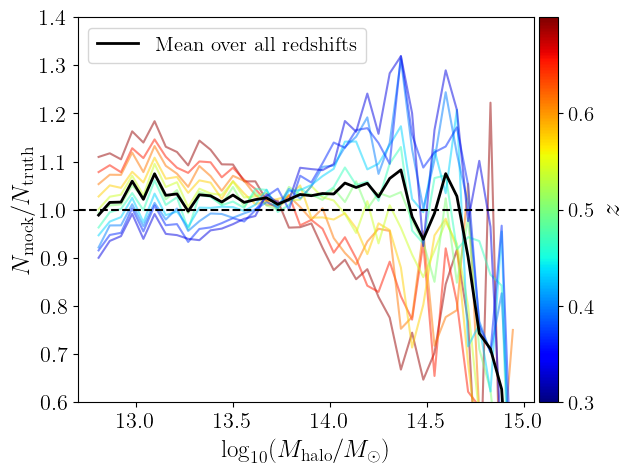

In [40]:
bin_cents_M = np.linspace(12.75, 15.0, 40)[1:-1]
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)
import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.3, vmax=0.7)

lgMass_truth_all_concat = []
lgMass_mock_all_concat = []
for jz in range(len(z_snap_sel)):
    saved_jz = saved_all_snaps[jz]
    lgMass_truth = saved_jz['lgMass_truth']
    lgMass_truth_all_concat.append(lgMass_truth)

    lgMass_mock = saved_jz['lgMass_mock']
    lgMass_mock_all_concat.append(lgMass_mock)

    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(lgMass_truth, bins=bin_edges_M)
    hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)

lgMass_truth_all_concat = np.concatenate(lgMass_truth_all_concat)
lgMass_mock_all_concat = np.concatenate(lgMass_mock_all_concat)
hist_truth_all, _ = np.histogram(lgMass_truth_all_concat, bins=bin_edges_M)
hist_mock_all, _ = np.histogram(lgMass_mock_all_concat, bins=bin_edges_M)
pl.plot(bin_cents_M, hist_mock_all/hist_truth_all, color='k', lw=2, label='Mean over all redshifts')
pl.legend(loc='best', fontsize=15)
pl.ylim(0.6, 1.4)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.3, 0.7, 0.1))
pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.ylabel(r'$N_{\rm mock}/N_{\rm truth}$', fontsize=18)
pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)




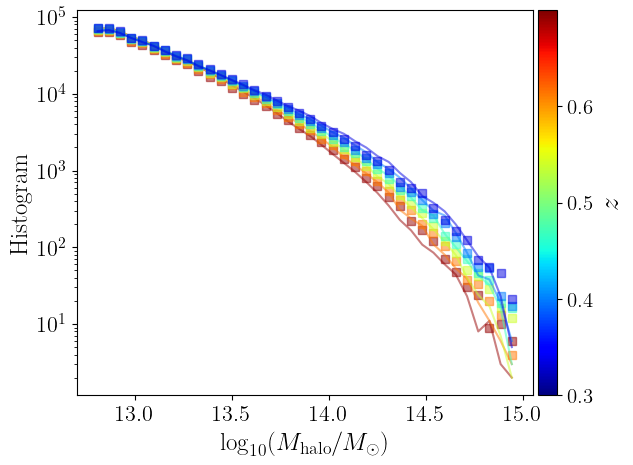

In [41]:
bin_cents_M = np.linspace(12.75, 15.0, 40)[1:-1]
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)
import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.3, vmax=0.7)

lgMass_truth_all_concat = []
lgMass_mock_all_concat = []
for jz in range(len(z_snap_sel))[::2]:
    saved_jz = saved_all_snaps[jz]
    lgMass_truth = saved_jz['lgMass_truth']
    lgMass_truth_all_concat.append(lgMass_truth)

    lgMass_mock = saved_jz['lgMass_mock']
    lgMass_mock_all_concat.append(lgMass_mock)

    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(lgMass_truth, bins=bin_edges_M)
    hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    # pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)
    pl.plot(bin_cents_M, hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)
    pl.plot(bin_cents_M, hist_mock, color=color_ji, ls = '-', alpha=0.5)

# lgMass_truth_all_concat = np.concatenate(lgMass_truth_all_concat)
# lgMass_mock_all_concat = np.concatenate(lgMass_mock_all_concat)
# hist_truth_all, _ = np.histogram(lgMass_truth_all_concat, bins=bin_edges_M)
# hist_mock_all, _ = np.histogram(lgMass_mock_all_concat, bins=bin_edges_M)
# # pl.plot(bin_cents_M, hist_mock_all/hist_truth_all, color='k', lw=2)
# pl.plot(bin_cents_M, hist_mock_all/len(z_snap_sel), color='k', ls='', marker='s')
# pl.plot(bin_cents_M, hist_mock_all/len(z_snap_sel), color='k',ls = '-', lw=2)

# pl.ylim(0.6, 1.4)
pl.yscale('log')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.3, 0.7, 0.1))
pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.ylabel(r'Histogram', fontsize=18)
# pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)





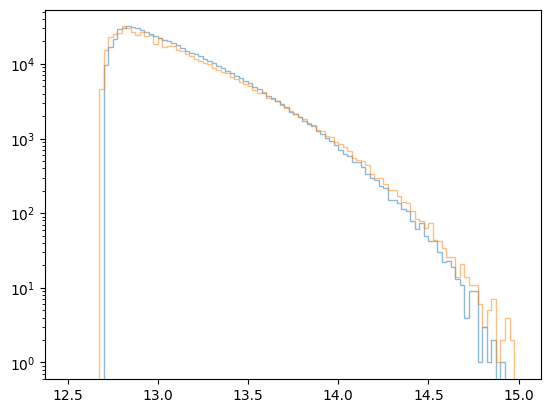

In [16]:
pl.figure()
_ = pl.hist(lgMass_mock, bins=100, alpha=0.5, label='mock', range=(12.5, 15), histtype='step')
_ = pl.hist(lgMass_truth, bins=100, alpha=0.5, label='truth', range=(12.5, 15), histtype='step')
pl.yscale('log')




In [2]:
%load_ext Cython


In [3]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_8000a7727c451ae88844bdd9f9cbdcc9.c:775:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [4]:
a_snap_all = np.loadtxt('/mnt/home/spandey/ceph/CHARM/data/camels_snap_scalefac.txt')
z_snap_all = 1/a_snap_all - 1
indsel = np.where((z_snap_all >= 0.0) & (z_snap_all <= 2.0))[0][::5]
a_snap_sel = a_snap_all[indsel]
z_snap_sel = z_snap_all[indsel]
snap_num_array = indsel


In [5]:
z_snap_sel

array([1.93174132, 1.60423452, 1.30237846, 1.04517821, 0.81670998,
       0.61376409, 0.43348941, 0.26733407, 0.12575933, 0.        ])

In [10]:
import MAS_library as MASL
# charm_data_ldir = '/mnt/home/spandey/ceph/test_CHARM_install/CHARM/charm_data/'
charm_data_ldir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/1gpc_90snap/0/'
cosmology_array = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
saved_all_snaps = {}
grid = 128
for jz in range(len(z_snap_sel)):
    saved_jz = {}
    z = np.round(z_snap_sel[jz], 4)
    # z_REDSHIFT = '0.5'
    z_REDSHIFT = str(z)

    root = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_HR/'
    ji = 0
    snapnum = snap_num_array[jz]
    snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
    ptypes       = [1]
    
    BoxSize = 1000.0 #Mpc/h ; size of box

    df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                    do_RSD=False, axis=0, verbose=True)
    df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

    snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_HR/Rockstar/0'
    snapnum = snap_num_array[jz]
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress
    # snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    indsel = np.where(mass_truth > 5e12)[0]
    pos_h_truth = pos_h_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]

    Nhalos = np.float32(np.zeros((grid, grid, grid)))
    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
    nMax_h = 10

    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)

    saved_jz['df_pylians_cic'] = df_pylians_cic
    saved_jz['Nhalos'] = Nhalos
    saved_jz['M_halos'] = M_halos

    saved_all_snaps[z_REDSHIFT] = saved_jz





Computing density field of particles [1]
1.07374180e+09 should be equal to
1.07374182e+09
Time taken = 70.50 seconds


/tmp/ipykernel_1378705/322199570.py:38: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)



Computing density field of particles [1]
1.07374180e+09 should be equal to
1.07374182e+09
Time taken = 74.01 seconds

Computing density field of particles [1]
1.07374179e+09 should be equal to
1.07374182e+09
Time taken = 69.70 seconds

Computing density field of particles [1]
1.07374179e+09 should be equal to
1.07374182e+09
Time taken = 76.92 seconds

Computing density field of particles [1]
1.07374179e+09 should be equal to
1.07374182e+09
Time taken = 72.69 seconds

Computing density field of particles [1]
1.07374178e+09 should be equal to
1.07374182e+09
Time taken = 75.30 seconds

Computing density field of particles [1]
1.07374178e+09 should be equal to
1.07374182e+09
Time taken = 77.37 seconds

Computing density field of particles [1]
1.07374178e+09 should be equal to
1.07374182e+09
Time taken = 79.17 seconds

Computing density field of particles [1]
1.07374177e+09 should be equal to
1.07374182e+09
Time taken = 84.56 seconds

Computing density field of particles [1]
1.07374177e+09

In [11]:
# sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.3-0.7.pk'
sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
pk.dump(saved_all_snaps, open(sfname, 'wb'))




In [6]:
# cosmology_array = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function




In [7]:
from colossus.lss import peaks
sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
saved_all_snaps = pk.load(open(sfname, 'rb'))
for jz in range(len(z_snap_sel)):
    saved_jz = {}
    z = np.round(z_snap_sel[jz], 4)
    z_REDSHIFT = str(z)
    saved_jz = saved_all_snaps[z_REDSHIFT]
    # df_pylians_cic = saved_jz['df_pylians_cic']
    Nhalos = saved_jz['Nhalos']
    M_halos = saved_jz['M_halos']

    M_halos_all_nonzero = M_halos[M_halos > 0]

    nu_all_nonzero = peaks.peakHeight(10**M_halos_all_nonzero, z)



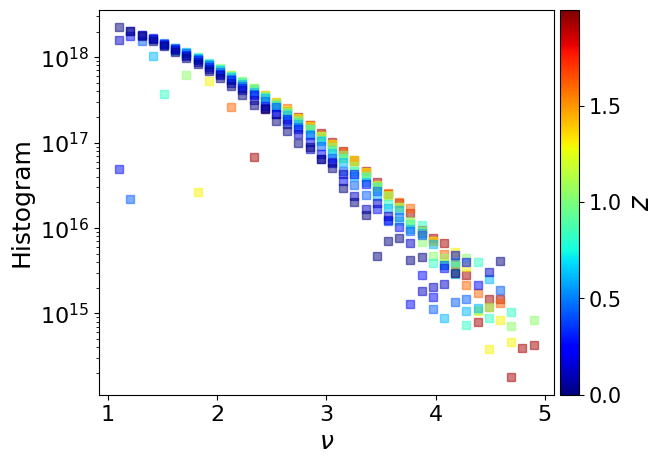

In [8]:
from colossus.lss import peaks
sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
saved_all_snaps = pk.load(open(sfname, 'rb'))


bin_cents_nu = np.linspace(1, 5.0, 40)[1:-1]
# bin_cents_nu = np.linspace(0.0, 2.0, 40)[1:-1]
bin_edges_nu = 0.5*(bin_cents_nu[1:] + bin_cents_nu[:-1])
delta_b = 0.5*(bin_cents_nu[1] - bin_cents_nu[0])
bin_edges_nu = np.insert(bin_edges_nu,0, bin_cents_nu[0] - delta_b)
bin_edges_nu = np.insert(bin_edges_nu,len(bin_edges_nu), bin_cents_nu[-1] + delta_b)
import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=2.0)

# lgMass_truth_all_concat = []
# lgMass_mock_all_concat = []
for jz in range(len(z_snap_sel)):
    z = np.round(z_snap_sel[jz], 4)
    z_REDSHIFT = str(z)
    saved_jz = saved_all_snaps[z_REDSHIFT]

    Nhalos = saved_jz['Nhalos']
    M_halos = saved_jz['M_halos']

    M_halos_all_nonzero = M_halos[M_halos > 0]

    nu_all_nonzero = (peaks.peakHeight(10**M_halos_all_nonzero, z))
    

    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(nu_all_nonzero, bins=bin_edges_nu)
    mass_from_nu = peaks.massFromPeakHeight(bin_cents_nu, z)
    # hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    # pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)
    pl.plot(bin_cents_nu, mass_from_nu*hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)
    # pl.plot(bin_cents_M, hist_mock, color=color_ji, ls = '-', alpha=0.5)

# lgMass_truth_all_concat = np.concatenate(lgMass_truth_all_concat)
# lgMass_mock_all_concat = np.concatenate(lgMass_mock_all_concat)
# hist_truth_all, _ = np.histogram(lgMass_truth_all_concat, bins=bin_edges_M)
# hist_mock_all, _ = np.histogram(lgMass_mock_all_concat, bins=bin_edges_M)
# # pl.plot(bin_cents_M, hist_mock_all/hist_truth_all, color='k', lw=2)
# pl.plot(bin_cents_M, hist_mock_all/len(z_snap_sel), color='k', ls='', marker='s')
# pl.plot(bin_cents_M, hist_mock_all/len(z_snap_sel), color='k',ls = '-', lw=2)

# pl.ylim(0.6, 1.4)
pl.yscale('log')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.0, 2.0, 0.5))
# pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.xlabel(r'$\nu$', fontsize=18)
pl.ylabel(r'Histogram', fontsize=18)
# pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)





In [10]:
import MAS_library as MASL
# charm_data_ldir = '/mnt/home/spandey/ceph/test_CHARM_install/CHARM/charm_data/'
charm_data_ldir = '/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm/1gpc_90snap/0/'
cosmology_array = np.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
saved_all_snaps = {}
grid = 128
for jz in range(len(z_snap_sel)):
    saved_jz = {}
    z = np.round(z_snap_sel[jz], 4)
    # z_REDSHIFT = '0.5'
    z_REDSHIFT = str(z)

    # root = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_HR/'
    # ji = 0
    # snapnum = snap_num_array[jz]
    # snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
    # ptypes       = [1]
    
    BoxSize = 1000.0 #Mpc/h ; size of box

    # df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
    #                                 do_RSD=False, axis=0, verbose=True)
    # df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0

    snapdir = '/mnt/home/fvillaescusa/ceph/Quijote/Matt/Sims/fiducial_HR/Rockstar/0'
    snapnum = snap_num_array[jz]
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress
    # snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    # index_M = header.index('M200c')                    
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    lgMass_truth = np.log10(mass_truth).astype(np.float32)
    vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

    indsel = np.where(mass_truth > 5e12)[0]
    pos_h_truth = pos_h_truth[indsel]
    vel_h_truth = vel_h_truth[indsel]
    lgMass_truth = lgMass_truth[indsel]

    Nhalos = np.float32(np.zeros((grid, grid, grid)))
    MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)
    nMax_h = 10

    dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
    NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

    M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)

    # saved_jz['df_pylians_cic'] = df_pylians_cic
    saved_jz['Nhalos'] = Nhalos
    saved_jz['M_halos'] = M_halos

    saved_all_snaps[z_REDSHIFT] = saved_jz




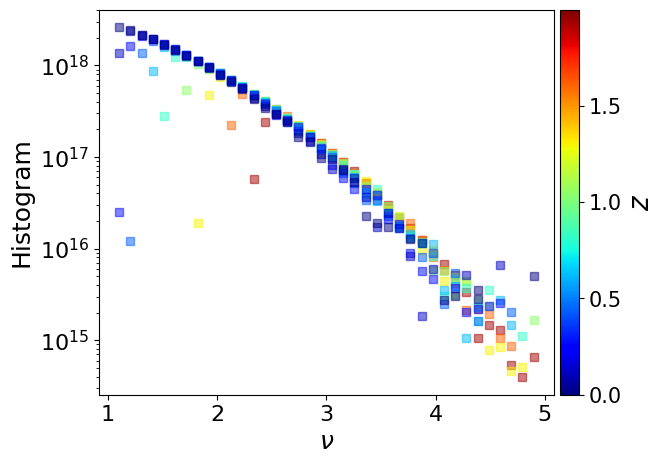

In [11]:
# from colossus.lss import peaks
# sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
# saved_all_snaps = pk.load(open(sfname, 'rb'))


bin_cents_nu = np.linspace(1, 5.0, 40)[1:-1]
# bin_cents_nu = np.linspace(0.0, 2.0, 40)[1:-1]
bin_edges_nu = 0.5*(bin_cents_nu[1:] + bin_cents_nu[:-1])
delta_b = 0.5*(bin_cents_nu[1] - bin_cents_nu[0])
bin_edges_nu = np.insert(bin_edges_nu,0, bin_cents_nu[0] - delta_b)
bin_edges_nu = np.insert(bin_edges_nu,len(bin_edges_nu), bin_cents_nu[-1] + delta_b)
import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=2.0)

# lgMass_truth_all_concat = []
# lgMass_mock_all_concat = []
for jz in range(len(z_snap_sel)):
    z = np.round(z_snap_sel[jz], 4)
    z_REDSHIFT = str(z)
    saved_jz = saved_all_snaps[z_REDSHIFT]

    Nhalos = saved_jz['Nhalos']
    M_halos = saved_jz['M_halos']

    M_halos_all_nonzero = M_halos[M_halos > 0]

    nu_all_nonzero = (peaks.peakHeight(10**M_halos_all_nonzero, z))
    

    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(nu_all_nonzero, bins=bin_edges_nu)
    mass_from_nu = peaks.massFromPeakHeight(bin_cents_nu, z)
    # hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    # pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)
    pl.plot(bin_cents_nu, mass_from_nu*hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)
    # pl.plot(bin_cents_M, hist_mock, color=color_ji, ls = '-', alpha=0.5)

# pl.ylim(0.6, 1.4)
pl.yscale('log')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.0, 2.0, 0.5))
# pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.xlabel(r'$\nu$', fontsize=18)
pl.ylabel(r'Histogram', fontsize=18)
# pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)





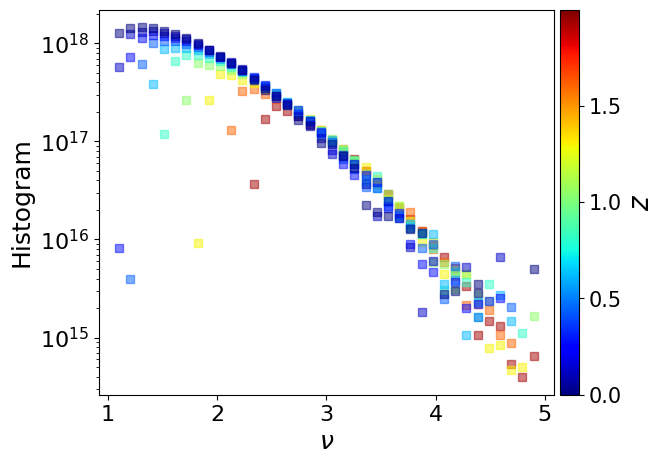

In [13]:
# from colossus.lss import peaks
# sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
# saved_all_snaps = pk.load(open(sfname, 'rb'))


bin_cents_nu = np.linspace(1, 5.0, 40)[1:-1]
# bin_cents_nu = np.linspace(0.0, 2.0, 40)[1:-1]
bin_edges_nu = 0.5*(bin_cents_nu[1:] + bin_cents_nu[:-1])
delta_b = 0.5*(bin_cents_nu[1] - bin_cents_nu[0])
bin_edges_nu = np.insert(bin_edges_nu,0, bin_cents_nu[0] - delta_b)
bin_edges_nu = np.insert(bin_edges_nu,len(bin_edges_nu), bin_cents_nu[-1] + delta_b)
import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=2.0)

for jz in range(len(z_snap_sel)):
    z = np.round(z_snap_sel[jz], 4)
    z_REDSHIFT = str(z)
    saved_jz = saved_all_snaps[z_REDSHIFT]

    Nhalos = saved_jz['Nhalos']
    M_halos = saved_jz['M_halos'][...,0]

    M_halos_all_nonzero = M_halos[M_halos > 0]

    nu_all_nonzero = (peaks.peakHeight(10**M_halos_all_nonzero, z))
    
    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(nu_all_nonzero, bins=bin_edges_nu)
    mass_from_nu = peaks.massFromPeakHeight(bin_cents_nu, z)
    # hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    # pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)
    pl.plot(bin_cents_nu, mass_from_nu*hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)
    # pl.plot(bin_cents_M, hist_mock, color=color_ji, ls = '-', alpha=0.5)

# pl.ylim(0.6, 1.4)
pl.yscale('log')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.0, 2.0, 0.5))
# pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.xlabel(r'$\nu$', fontsize=18)
pl.ylabel(r'Histogram', fontsize=18)
# pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)





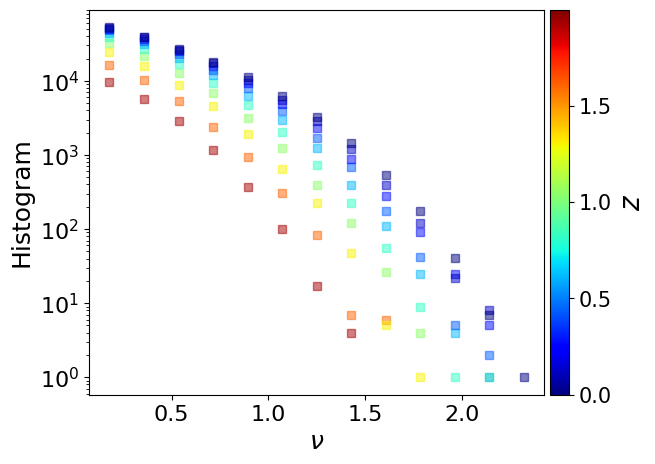

In [15]:
# from colossus.lss import peaks
# sfname = '/mnt/home/spandey/ceph/CHARM/data/truth_density_halos_1Gpc_90snap_z0.0-2.0.pk'
# saved_all_snaps = pk.load(open(sfname, 'rb'))


# bin_cents_nu = np.linspace(1, 5.0, 40)[1:-1]
# bin_edges_nu = 0.5*(bin_cents_nu[1:] + bin_cents_nu[:-1])
# delta_b = 0.5*(bin_cents_nu[1] - bin_cents_nu[0])
# bin_edges_nu = np.insert(bin_edges_nu,0, bin_cents_nu[0] - delta_b)
# bin_edges_nu = np.insert(bin_edges_nu,len(bin_edges_nu), bin_cents_nu[-1] + delta_b)
bin_cents_M = np.linspace(0.0, 2.5, 15)[1:-1]
bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)


import matplotlib
fig, axes = pl.subplots(1,1, figsize=(7,5))
from matplotlib import cm
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=2.0)

for jz in range(len(z_snap_sel)):
    z = np.round(z_snap_sel[jz], 4)
    z_REDSHIFT = str(z)
    saved_jz = saved_all_snaps[z_REDSHIFT]

    Nhalos = saved_jz['Nhalos']
    M_halos = saved_jz['M_halos']
    M_halos_diff = M_halos[...,0] - M_halos[...,1]

    M_halos_all_nonzero = M_halos_diff[M_halos_diff > 0]

    # nu_all_nonzero = (peaks.peakHeight(10**M_halos_all_nonzero, z))
    
    z_jz = z_snap_sel[jz]
    color_ji = cm.jet(norm(z_jz)) 

    hist_truth, _ = np.histogram(M_halos_all_nonzero, bins=bin_edges_M)
    # mass_from_nu = peaks.massFromPeakHeight(bin_cents_nu, z)
    # hist_mock, _ = np.histogram(lgMass_mock, bins=bin_edges_M)
    # pl.plot(bin_cents_M, hist_mock/hist_truth, color=color_ji, alpha=0.5)
    # pl.plot(bin_cents_nu, mass_from_nu*hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)
    pl.plot(bin_cents_M, hist_truth, color=color_ji, ls='', marker='s', alpha=0.5)    
    # pl.plot(bin_cents_M, hist_mock, color=color_ji, ls = '-', alpha=0.5)

# pl.ylim(0.6, 1.4)
pl.yscale('log')
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=axes, label=r'$z$', pad=0.01)
# set labelsize and colorbar location:
# cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\sigma_8$', size=18)
cbar.set_label(r'$z$', size=20)
cbar.set_ticks(np.arange(0.0, 2.0, 0.5))
# pl.xlabel(r'$\log_{10}(M_{\rm halo}/M_{\odot})$', fontsize=18)
pl.xlabel(r'$\nu$', fontsize=18)
pl.ylabel(r'Histogram', fontsize=18)
# pl.axhline(1, color='k', ls='--')
pl.tick_params(axis='both', which='major', labelsize=16)
pl.tick_params(axis='both', which='minor', labelsize=16)



